# Background removal using Sementic Segmentation Network Unet



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.python.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.utils import multi_gpu_model, plot_model ,Sequence
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.preprocessing.image import load_img,img_to_array
import tensorflow as tf
from tensorflow.python.keras.losses import binary_crossentropy
from scipy.ndimage import morphology as mp

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
from glob import glob  # for getting list paths of image and labels
from random import choice,sample
from matplotlib import pyplot as plt
import cv2 # saving and loading images

# Any results you write to the current directory are saved as output.

['plant-pathology-2021-fgvc8', 'eron-masks']


# listing image and their respective labels 
also here we are asserting the presence of label file w.r.t each image.

In [2]:
train_img_dir = '../input/plant-pathology-2021-fgvc8/train_images/' 
train_mask_dir = '../input/eron-masks/masks/'
train_imgs = os.listdir(train_mask_dir)# if you have an error take a look here ...
train_masks = os.listdir(train_mask_dir)
train_imgs= [ i for i in train_imgs if "jpg" in i][:-100]
train_masks= [ i for i in train_masks if "jpg" in i][:-100]
print(len(train_imgs))
print(len(train_masks))


9900
9900


**Repeat same steps for validation dataset**

In [3]:
val_img_dir = '../input/plant-pathology-2021-fgvc8/train_images/'
val_mask_dir = '../input/eron-masks/masks/'
val_imgs = train_imgs[-100:]#os.listdir(val_mask_dir)
val_masks = train_masks[-100:]#os.listdir(val_mask_dir)
print(len(val_imgs))
print(len(val_masks))

100
100


# Here we impliment keras custom data generator to get batch images and labels without loading whole dataset in the active memory


In [4]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, images,image_dir,labels,label_dir ,batch_size=16, dim=(224,224,3) ,shuffle=True):
        'Initialization'
        self.dim = dim
        self.images = images
        self.image_dir = image_dir
        self.labels = labels
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.image_dir + self.images[i] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)
           # Store class
            label = load_img(self.label_dir + self.labels[i] ,target_size=self.dim)
            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

 **Now we need to define our training and validation generator using above implimented class.**

In [5]:
train_generator = DataGenerator(train_imgs,train_img_dir,train_masks,train_mask_dir,batch_size=36, dim=(224,224,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

275

**After defining generator lets check the some of the dataset it generates for the training and visualize them**

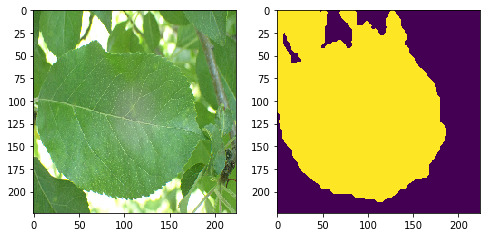

In [6]:
X,y = train_generator.__getitem__(5)
t = 27
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(X[t])
plt.subplot(122)
plt.imshow(np.reshape(y[t],(224,224)))
#print(np.unique(y[t],return_counts=True))

In [7]:
val_generator = DataGenerator(val_imgs,val_img_dir,val_masks,val_mask_dir,batch_size=36, dim=(224,224,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

2

# After preparing input pipeline we are going to define our U-net model

here we first define down convolution (encoder ) and up convolution layer (decoder) and stack them up with a short circuting features from down sampling to corresponding up sampling

full detail of the  architecture is present here - https://arxiv.org/abs/1505.04597

In [8]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(deconv9)
    # using sigmoid activation for binary classification
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [9]:
model = Unet(224 , 224 , 34)
#model.summary()

# Here we define keras custom metric for the loss and accuracy computation

Jaccard distance loss - this loss help to get rid of the side effects of unbalanced class label in a image (like - 80% background , 20 % human )  https://en.wikipedia.org/wiki/Jaccard_index

dice_coef - To evaluate accuracy of the segmentation.   https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

In [10]:
def jaccard_distance_loss(y_true, y_pred,smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

# Defining callbacks and compile model with adam optimiser with default learning rate.

In [11]:
model.compile(optimizer='adam', loss=jaccard_distance_loss ,metrics = [dice_coef, 'accuracy'])
mc = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='val_dice_coef',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_dice_coef', patience=3, verbose=1)
callbacks = [mc, es]
model.metrics_names

['loss', 'dice_coef', 'acc']

# Now finally train our model with above configuration and train data generator.

In [12]:
results = model.fit_generator(train_generator, steps_per_epoch=train_steps,epochs=1,callbacks=callbacks,validation_data=val_generator,validation_steps=val_steps)

Epoch 1/1
274/275 [============================>.] - ETA: 6s - loss: 6.5679 - dice_coef: 0.7612 - acc: 0.8252 
Epoch 00001: val_dice_coef improved from -inf to 0.77407, saving model to top-weights.h5
275/275 [==============================] - 1735s 6s/step - loss: 6.5678 - dice_coef: 0.7612 - acc: 0.8252 - val_loss: 5.7329 - val_dice_coef: 0.7741 - val_acc: 0.8425


** Visualizing train and val loss w.r.t epoch**

In [13]:
# plt.figure(figsize=(8, 8))
# plt.title("Learning curve")
# plt.plot(results.history["loss"], label="loss")
# plt.plot(results.history["val_loss"], label="val_loss")
# plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
# plt.xlabel("Epochs")
# plt.ylabel("log_loss")
# plt.legend();

In [14]:
#model.load_weights('/kaggle/input/background-removal/weights.08-0.97.h5')
#k = model.evaluate_generator(generator=val_generator,steps=val_steps)

# Now its time to make some predictions

In [15]:
test_image = glob('../input/plant-pathology-2021-fgvc8/test_images')
#mask_set = glob('/kaggle/input/back-remove/binary_segment/binary_segment/train/masks/1004.jpg')
#len(test_image)

In [16]:
# def jaccard_distance(y_true, y_pred, smooth=100):
#     intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#     sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
#     jac = (intersection + smooth) / (sum_ - intersection + smooth)
#     return (1 - jac) * smooth

# def jaccard_acc(y_true, y_pred):
#     intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#     sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
#     jac = intersection / sum_ - intersection
#     return jac

# img = img_to_array(load_img(test_image[0]))
# mask = img_to_array(load_img(mask_set[0]))
# plt.imshow(mask/255.)

# jaccard_distance_loss(mask[:,:,0],mask[:,:,0])

**Function to make prediction 
Note:-  Dont forget to Normalise image dataset (here i divided every pixel by 255. )**

In [17]:
def make_prediction(model,image,shape):
    img = img_to_array(load_img(image,target_size=shape))
    img = np.expand_dims(img,axis=0)/255.
    mask = model.predict(img)
    
    mask = mask[0] > 0.5
    print(np.unique(mask,return_counts=True))
    mask = np.reshape(mask,(224,224))
    return mask                       

(3456, 5184, 3)

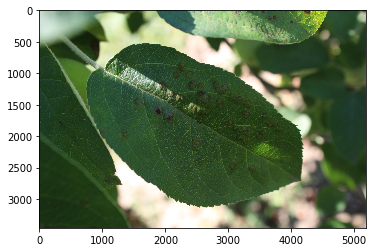

In [18]:
image = "../input/plant-pathology-2021-fgvc8/test_images/85f8cb619c66b863.jpg"
img = img_to_array(load_img(image))
plt.imshow(img/255.)
img.shape

(array([False,  True]), array([32567, 17609]))


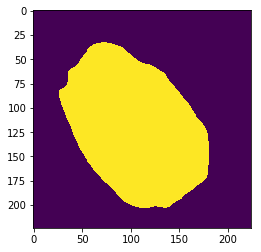

In [19]:
mask = make_prediction(model,image,(224,224,3))
plt.imshow(mask)

**Now use the mask to get the segmented image**

In [20]:
h,w = img.shape[:2]
mask_resized = cv2.resize(np.uint8(mask*1),(w,h))
mask_resized = mask_resized != 0
#print(np.unique(mask_resized,return_counts=True))
segment = np.zeros((h,w,3))
segment[:,:,0] = img[:,:,0]*mask_resized
segment[:,:,1] = img[:,:,1]*mask_resized
segment[:,:,2] = img[:,:,2]*mask_resized
segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]
#img[np.where((img==[255,255,255]).all(axis=2))] = [0,0,0];

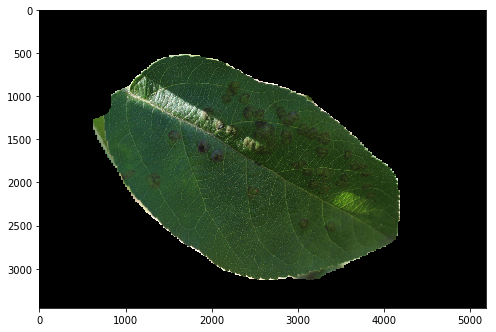

In [21]:
plt.figure(figsize=(8,8))
plt.imshow(segment/255.)